# Predicting the Mental Health State of University Students

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import sem

#Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#We will use sklearn for building logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold
from sklearn.datasets import make_classification
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz

In [11]:
df = pd.read_csv('Student Mental health.csv') # raw datafile

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Timestamp                                     101 non-null    object 
 1   Choose your gender                            101 non-null    object 
 2   Age                                           100 non-null    float64
 3   What is your course?                          101 non-null    object 
 4   Your current year of Study                    101 non-null    object 
 5   What is your CGPA?                            101 non-null    object 
 6   Marital status                                101 non-null    object 
 7   Do you have Depression?                       101 non-null    object 
 8   Do you have Anxiety?                          101 non-null    object 
 9   Do you have Panic attack?                     101 non-null    obj

In [13]:
df.describe()

,Age
count,100.00000
mean,20.53000
std,2.49628
min,18.00000
25%,18.00000
50%,19.00000
75%,23.00000
max,24.00000


In the next cells, some unimportant columns are removed and columns are renamed

In [14]:
df.drop(columns=["Timestamp", "What is your course?", "Did you seek any specialist for a treatment?"], inplace = True)

In [15]:
df

,Choose your gender,Age,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?
0,Female,18.0,year 1,3.00 - 3.49,No,Yes,No,Yes
1,Male,21.0,year 2,3.00 - 3.49,No,No,Yes,No
2,Male,19.0,Year 1,3.00 - 3.49,No,Yes,Yes,Yes
3,Female,22.0,year 3,3.00 - 3.49,Yes,Yes,No,No
4,Male,23.0,year 4,3.00 - 3.49,No,No,No,No
...,...,...,...,...,...,...,...,...
96,Female,21.0,year 1,3.50 - 4.00,No,No,Yes,No
97,Male,18.0,Year 2,3.00 - 3.49,No,Yes,Yes,No
98,Female,19.0,Year 3,3.50 - 4.00,Yes,Yes,No,Yes
99,Female,23.0,year 4,3.50 - 4.00,No,No,No,No


In [16]:
df.columns = ["gender", "age", "year", "gpa", "marital_status", "depression", "anxiety", "panic"]

Changing the years and gpa into single values. Gpa is classified so that lowest range is 1, second lowest 2 etc. 

In [17]:
df['year'].replace({'Year 2': '2' , 'year 2':'2' , 'Year 3':'3' , 'year 3':'3' , 'Year 1':'1','year 4':'4','year 1': '1'} , inplace = True)
df['gpa'].replace({'0 - 1.99': '1' , '2.00 - 2.49':'2' , '2.50 - 2.99':'3' , '3.00 - 3.49':'4' , '3.50 - 4.00':'5', '3.50 - 4.00 ':'5'} , inplace = True)
df['marital_status'].replace({'Yes': '1' , 'yes':'1' , 'No':'0' , 'no':'0'} , inplace = True)

In [18]:
df['depression'].replace({'Yes': '1' , 'No':'0'} , inplace = True) 
df['anxiety'].replace({'Yes': '1' , 'No':'0'} , inplace = True) 
df['panic'].replace({'Yes': '1' , 'No':'0'} , inplace = True)

In [19]:
mental_health = []
i = 0
while i < 101:
    if df["depression"][i] == "0" and df["anxiety"][i] == "0" and df["panic"][i] == "0":
        status = 0
    else:
        status = 1
    i +=1
    mental_health.append(status)

df["mental_health"] = mental_health

In [20]:
df = df.drop(columns=["depression", "anxiety", "panic"])

In [21]:
df = df.dropna()

In [22]:
df['mental_health'].value_counts(normalize=True) # class imbalance

1    0.64
0    0.36
Name: mental_health, dtype: float64

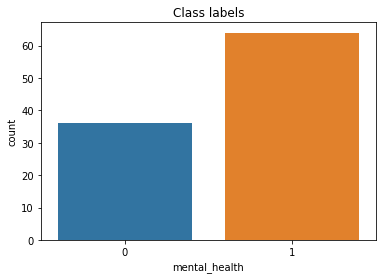

In [23]:
# plot of the label distribution
sns.countplot(x="mental_health", data=df) 
plt.title("Class labels")
plt.show()

In [24]:
df = df.dropna()
df_dummies = pd.get_dummies(df)
df_dummies.head()

,age,mental_health,gender_Female,gender_Male,year_1,year_2,year_3,year_4,gpa_1,gpa_2,gpa_3,gpa_4,gpa_5,marital_status_0,marital_status_1
0,18.0,1,1,0,1,0,0,0,0,0,0,1,0,1,0
1,21.0,1,0,1,0,1,0,0,0,0,0,1,0,1,0
2,19.0,1,0,1,1,0,0,0,0,0,0,1,0,1,0
3,22.0,1,1,0,0,0,1,0,0,0,0,1,0,0,1
4,23.0,0,0,1,0,0,0,1,0,0,0,1,0,1,0


In [25]:
#df.head()

In [26]:
# converting data types to numeric and checking their correlation

# df['year'] = pd.to_numeric(df['year'])

#corr_plot = sns.heatmap(df.corr(),annot = True,linewidths=3 )
#plt.title("Correlation plot")
#plt.show()

In [27]:
scaler = MinMaxScaler()
df_dummies['age'] = scaler.fit_transform(df_dummies[['age']])

features = ['age', 'year_1', 'year_2', 'year_3', 'year_4', 'gender_Male', 'gender_Female', 'gpa_1', 'gpa_2', 'gpa_3', 'gpa_4', 'gpa_5', 'marital_status_0', 'marital_status_1']
X = df_dummies[features].to_numpy()
y = df_dummies['mental_health'].to_numpy()

print(X.shape)
print(y.shape)

(100, 14)
(100,)


In [28]:
#separating the testing set for the final comparison between models
X_cross, X_test, y_cross, y_test = train_test_split(X,y,random_state=0,train_size=0.80)
print(X_cross.shape)
print(X_test.shape)
print(y_cross.shape)
print(y_test.shape)

(80, 14)
(20, 14)
(80,)
(20,)


In [29]:
#fitting the logistic regression model
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

#cross-validation of logistic regression model
model_lr = LogisticRegression(solver='liblinear')
results = cross_val_score(model_lr, X_cross, y_cross, cv=kfold)

# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 63.750% (8.292%)


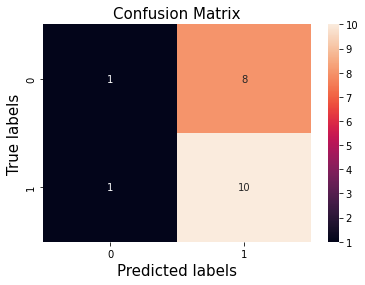

Prediction accuracy: 55.00%


In [38]:
# fitting and testing the cross validation model

model_lr.fit(X_cross, y_cross)

def generate_confusion_matrix(y_true, y_pred):
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)
    
y_pred = model_lr.predict(X_test)

generate_confusion_matrix(y_test, y_pred)
plt.show()
multi_accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")


In [31]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.56      0.91      0.69        11

    accuracy                           0.55        20
   macro avg       0.53      0.51      0.44        20
weighted avg       0.53      0.55      0.46        20



In [32]:
model_dt = DecisionTreeClassifier(criterion="entropy", class_weight='balanced', random_state=0) # criterion entropuy ??
results = cross_val_score(model_dt, X_cross, y_cross, cv=kfold)

# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 61.250% (12.119%)


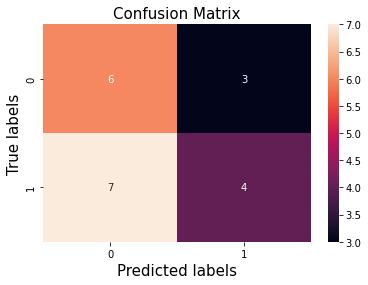

Prediction accuracy: 50.00%


In [33]:
model_dt.fit(X_cross, y_cross)

def generate_confusion_matrix(y_true, y_pred):
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)
    
y_pred = model_dt.predict(X_test)

generate_confusion_matrix(y_test, y_pred)
plt.show()
multi_accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")

In [34]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       0.57      0.36      0.44        11

    accuracy                           0.50        20
   macro avg       0.52      0.52      0.49        20
weighted avg       0.52      0.50      0.49        20



In [35]:
import pydotplus

d_tree = export_graphviz(model_dt, feature_names = features, filled = True, class_names=["mental_illness", "healthy"]) 
pydot_graph = pydotplus.graph_from_dot_data(d_tree) 
pydot_graph.write_pdf('tree.pdf')

Fontconfig error: Cannot load default config file: No such file: (null)



True